# VacationPy
----

#### Note
* Keep an eye on your API usage. Use https://developers.google.com/maps/reporting/gmp-reporting as reference for how to monitor your usage and billing.

* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import csv
import json

# Import API key
from config import g_key

### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [3]:
csv_weather_path = "../WeatherPy/weather_search.csv"
weather_df = pd.read_csv(csv_weather_path)

### Humidity Heatmap


In [4]:
gmaps.configure(api_key=g_key)

locations = weather_df[["latitude","longitude"]].astype(float)
humidity=weather_df["humidity"].astype(float)

cabo_coordinates = (22.8909, -109.9124)

figure_layout = {
    #'width': '500px',
    'height': '420px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout,center=cabo_coordinates,zoom_level=2,map_type='ROADMAP')

heat_layer = gmaps.heatmap_layer(locations,weights=humidity,dissipating=False,max_intensity=100,point_radius=2)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(border='1px solid black', height='420px', margin='0 auto 0 auto', padding='1px'))

### Create new DataFrame fitting weather criteria


In [5]:
#Create dataframe with ideal weather conditions
vacay_options=weather_df[(weather_df['max_temp']>70)&(weather_df['max_temp']<80)&(weather_df['humidity']<30)&(weather_df['cloudiness']<30)]
vacay_options.head()

,city,city_id,country,latitude,longitude,temperature,max_temp,cloudiness,humidity,wind_speed
48,Cabo San Lucas,3985710,MX,22.8909,-109.9124,71.53,72.00,1,21,10.22
70,Saint George,5546220,US,37.1041,-113.5841,74.08,75.20,1,15,14.97
140,Adrar,2381972,MR,20.5022,-10.0711,75.15,75.15,6,16,8.48
317,Alice Springs,2077895,AU,-23.7000,133.8833,73.72,73.99,0,25,10.36
391,Yulara,6355222,AU,-25.2406,130.9889,73.40,73.40,0,27,16.11


### Hotel Map


In [6]:
#Create hotel dataframe to store hotel info
hotel_df=pd.DataFrame(vacay_options,columns=["city","country","hotel_lat","hotel_lng"])
hotel_df["hotel_name"]=""
hotel_df


,city,country,hotel_lat,hotel_lng,hotel_name
48,Cabo San Lucas,MX,NaN,NaN,
70,Saint George,US,NaN,NaN,
140,Adrar,MR,NaN,NaN,
317,Alice Springs,AU,NaN,NaN,
391,Yulara,AU,NaN,NaN,
462,Mīrābād,AF,NaN,NaN,
469,Birin,NP,NaN,NaN,
515,Khāsh,IR,NaN,NaN,


In [7]:
#Fill in hotel dataframe with hotel info
hotel_name = []

#city = hotel_df['city']
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json?"

params = {
    "radius": 5000,
    "type": "hotel",
    "key": g_key
}

for index, row in vacay_options.iterrows():
    #get latitude & longitude
    lat=row['latitude']
    lon=row['longitude']
    city=row['city']
    #print lat & long for iteration
    params["location"]=f"{lat},{lon}"
            
    response = requests.get(base_url, params=params).json()
    
    try:
        print(f"For {city} the closest hotel is {response['results'][1]['name']}.")
        hotel_df.loc[index, 'hotel_name'] = response['results'][1]['name']
        hotel_df.loc[index, 'hotel_lat'] = response['results'][1]['geometry']['location']['lat']
        hotel_df.loc[index, 'hotel_lng'] = response['results'][1]['geometry']['location']['lng']
    except IndexError:
        print(f"No hotel avaialable in {city}")
    
    print("---------------------")


For Cabo San Lucas the closest hotel is Hotel Tesoro Los Cabos.
---------------------
For Saint George the closest hotel is Best Western Plus Abbey Inn.
---------------------
No hotel avaialable in Adrar
---------------------
For Alice Springs the closest hotel is Desert Palms Alice Springs.
---------------------
For Yulara the closest hotel is Desert Gardens Hotel - Ayers Rock Resort.
---------------------
No hotel avaialable in Mīrābād
---------------------
For Birin the closest hotel is Rastriya Banijya Bank.
---------------------
For Khāsh the closest hotel is Badran Gostaran Co..
---------------------


In [8]:
#Cleanup hotel_df for remaining steps
hotel_df.columns = ['City', 'Country', 'Lat','Lng','Hotel Name']
hotel_df = hotel_df.dropna()
hotel_df


,City,Country,Lat,Lng,Hotel Name
48,Cabo San Lucas,MX,22.880938,-109.911797,Hotel Tesoro Los Cabos
70,Saint George,US,37.089025,-113.584267,Best Western Plus Abbey Inn
317,Alice Springs,AU,-23.713395,133.879820,Desert Palms Alice Springs
391,Yulara,AU,-25.243725,130.984807,Desert Gardens Hotel - Ayers Rock Resort
469,Birin,NP,26.895244,88.069087,Rastriya Banijya Bank
515,Khāsh,IR,28.218871,61.212955,Badran Gostaran Co.


In [9]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Hotel Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Country</dt><dd>{Country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in hotel_df.iterrows()]
locations = hotel_df[["Lat", "Lng"]]


In [10]:
# Add marker layer ontop of heat map

marker_layer = gmaps.marker_layer(locations,info_box_content=hotel_info)

fig.add_layer(marker_layer)
fig
# Display figure


Figure(layout=FigureLayout(border='1px solid black', height='420px', margin='0 auto 0 auto', padding='1px'))

### Humidity Heatmap Screenshot:

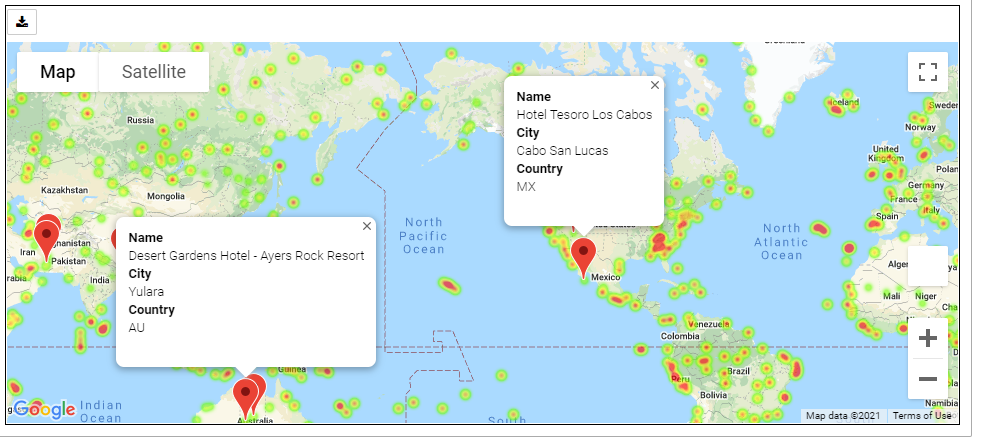
